In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [2]:
classes = 4
image_path = f'images'

train_path = f'{image_path}/train/'
test_path = f'{image_path}/test/'

In [3]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_path, 'train')
test_count = count_exp(test_path, 'test')
print('train', train_count)
print('test', test_count)

train        furious  irritated  scared  worried
train       99        117      88       87
test       furious  irritated  scared  worried
test       27         33      24       24


<AxesSubplot:>

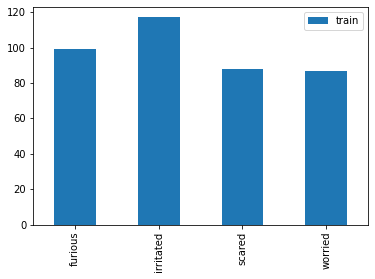

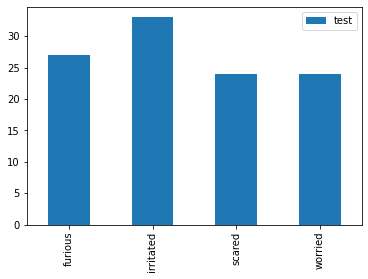

In [4]:
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3, 
                                    horizontal_flip=True, 
                                    validation_split=0.2)
                                    
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_path,
                                                 batch_size=1,
                                                 target_size=(48,48),
                                                 shuffle=False,
                                                 color_mode='grayscale',
                                                 class_mode='categorical',
                                                 subset = 'training'
                                                )
                            
val_set = val_datagen.flow_from_directory(train_path, 
                                            batch_size=1, 
                                            target_size=(48,48),
                                            shuffle=False,
                                            color_mode='grayscale',
                                            class_mode='categorical',
                                            subset = 'validation'
                                           )

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                                batch_size=1,
                                                target_size=(48,48),
                                                shuffle=False,
                                                color_mode='grayscale',
                                                class_mode='categorical'
                                            )

Found 315 images belonging to 4 classes.
Found 76 images belonging to 4 classes.
Found 108 images belonging to 4 classes.


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\preprocessing\image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [6]:
training_set.class_indices

{'furious': 0, 'irritated': 1, 'scared': 2, 'worried': 3}

In [7]:
def get_model(input_size, classes):
    #initializing the CNN
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [8]:
secondary_emotion_set = get_model((48, 48, 1), classes)
secondary_emotion_set.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


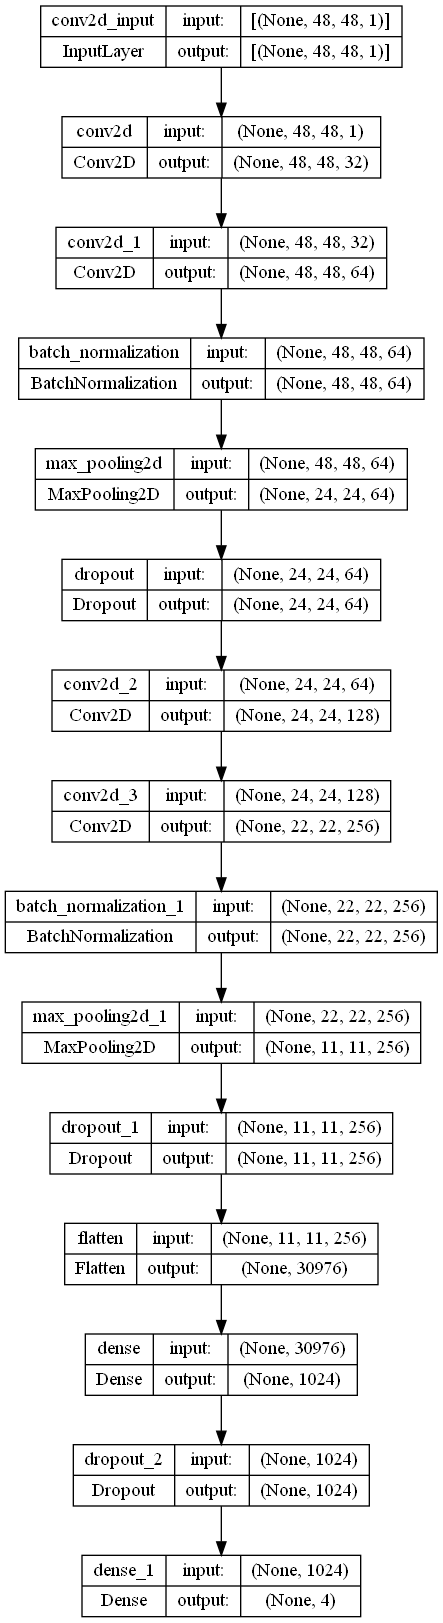

In [9]:
plot_model(secondary_emotion_set, to_file=f'secondary_emotion_set.png', show_shapes=True, show_layer_names=True)

In [10]:
chk_path = f'secondary_emotion_set.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(moniter='val_loss',
                             filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [11]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = val_set.n // val_set.batch_size

hist = secondary_emotion_set.fit(x=training_set,
                 validation_data=val_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
313/315 [============================>.] - ETA: 0s - loss: 10.0178 - accuracy: 0.3738
Epoch 1: val_loss improved from inf to 5.88554, saving model to secondary_emotion_set.h5
315/315 [==============================] - 6s 12ms/step - loss: 9.9925 - accuracy: 0.3746 - val_loss: 5.8855 - val_accuracy: 0.3947 - lr: 1.0000e-04
Epoch 2/60
312/315 [============================>.] - ETA: 0s - loss: 8.1398 - accuracy: 0.3141
Epoch 2: val_loss did not improve from 5.88554
315/315 [==============================] - 3s 10ms/step - loss: 8.1505 - accuracy: 0.3143 - val_loss: 5.9163 - val_accuracy: 0.2895 - lr: 1.0000e-04
Epoch 3/60
315/315 [==============================] - ETA: 0s - loss: 6.2198 - accuracy: 0.2571
Epoch 3: val_loss improved from 5.88554 to 5.06889, saving model to secondary_emotion_set.h5
315/315 [==============================] - 4s 14ms/step - loss: 6.2198 - accuracy: 0.2571 - val_loss: 5.0689 - val_accuracy: 0.3026 - lr: 1.0000e-04
Epoch 4/60
312/315 [===============

# Loss & accuracy


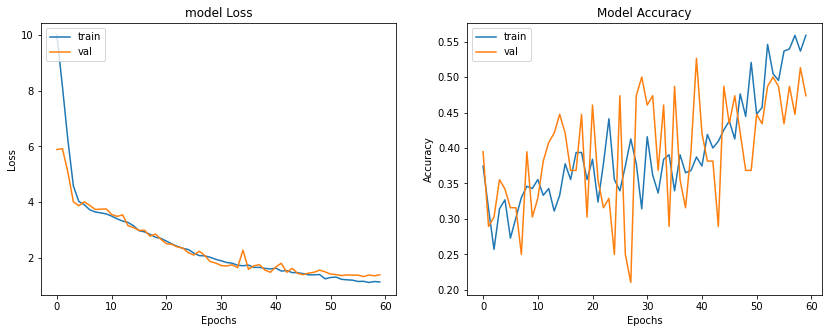

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test


In [18]:
train_loss, train_accu = secondary_emotion_set.evaluate(training_set)
test_loss, test_accu = secondary_emotion_set.evaluate(test_set)
print("final train accuracy = {:.2f} , test accuracy = {:.2f}".format(train_accu*100, test_accu*100))

108/108 [==============================] - 0s 4ms/step - loss: 1.2871 - accuracy: 0.5463
final train accuracy = 53.97 , test accuracy = 54.63


# Save weights


In [19]:
secondary_emotion_set.save_weights(f'secondary_emotion_bestweight.h5')

# Confusion matrix on train set


In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [47]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Refer to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label',fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    fontsize=20,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

315/315 [==============================] - 1s 2ms/step
Confusion Matrix
[[43 20 10  7]
 [ 8 77  5  4]
 [11 13 18 29]
 [12 11  7 40]]
Classification Report
              precision    recall  f1-score   support

     furious       0.58      0.54      0.56        80
   irritated       0.64      0.82      0.72        94
      scared       0.45      0.25      0.32        71
     worried       0.50      0.57      0.53        70

    accuracy                           0.57       315
   macro avg       0.54      0.55      0.53       315
weighted avg       0.55      0.57      0.55       315

Normalized confusion matrix
[[0.5375     0.25       0.125      0.0875    ]
 [0.08510638 0.81914894 0.05319149 0.04255319]
 [0.15492958 0.18309859 0.25352113 0.4084507 ]
 [0.17142857 0.15714286 0.1        0.57142857]]


<AxesSubplot:title={'center':'Confusion matrix on train set'}, xlabel='Predicted label', ylabel='True label'>

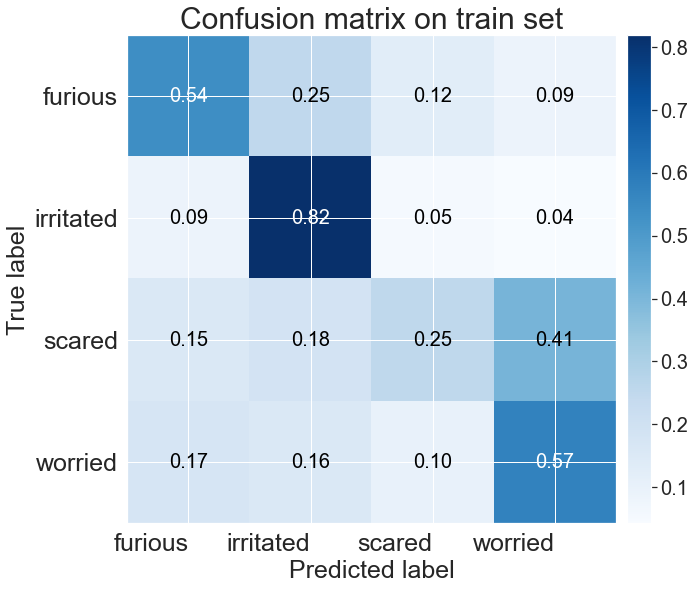

In [53]:
y_pred = secondary_emotion_set.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plot_confusion_matrix(training_set.classes, y_pred,
                      classes=np.array(target_names),
                      normalize=True,
                      title='Confusion matrix on train set')

# Confusion matrix on test set


108/108 [==============================] - 0s 3ms/step
Confusion Matrix
[[ 9 13  1  4]
 [ 1 30  0  2]
 [ 2  3  5 14]
 [ 3  3  3 15]]
Classification Report
              precision    recall  f1-score   support

     furious       0.60      0.33      0.43        27
   irritated       0.61      0.91      0.73        33
      scared       0.56      0.21      0.30        24
     worried       0.43      0.62      0.51        24

    accuracy                           0.55       108
   macro avg       0.55      0.52      0.49       108
weighted avg       0.56      0.55      0.51       108

Normalized confusion matrix
[[0.33333333 0.48148148 0.03703704 0.14814815]
 [0.03030303 0.90909091 0.         0.06060606]
 [0.08333333 0.125      0.20833333 0.58333333]
 [0.125      0.125      0.125      0.625     ]]


<AxesSubplot:title={'center':'Confusion matrix on test set'}, xlabel='Predicted label', ylabel='True label'>

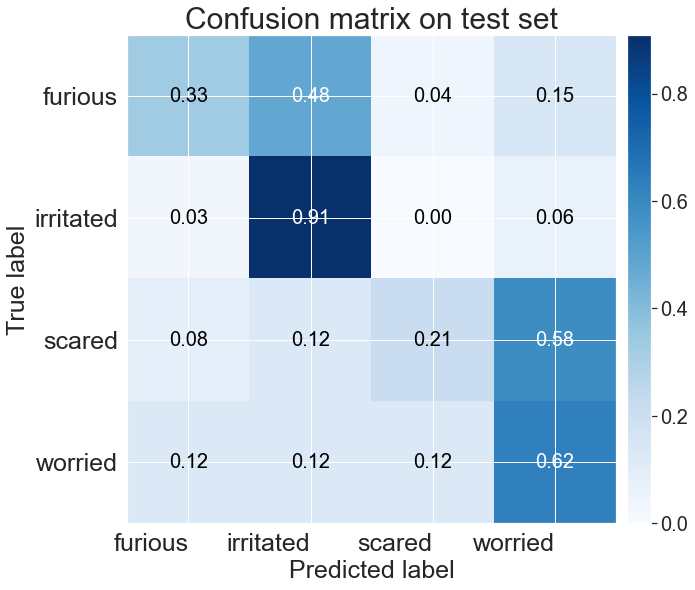

In [51]:
y_pred = secondary_emotion_set.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plot_confusion_matrix(test_set.classes, y_pred, 
                      classes=np.array(target_names),
                      normalize=True,
                      title='Confusion matrix on test set')